### Reading the Data

In [34]:
import pandas as pd
import numpy as np

def read_data(file_path):
    data = pd.read_csv(file_path, sep=';',decimal=',')
    data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
    
    # Forward fill missing values
    # data.fillna(method='ffill', inplace=True)

    return data

file_path = 'challenge_data.csv'
data = read_data(file_path)
print(data.head())

    datetime  Bremen_Apr  Bremen_Mai  Bremen_Jun  Oldenburg_Apr  \
0 2021-02-06         7.3        11.8        20.0            7.4   
1 2021-02-07         6.1        13.4        22.0            6.1   
2 2021-02-08         5.0        10.2        20.8            4.6   
3 2021-02-09         4.7        14.5        22.8            6.2   
4 2021-02-10         5.2        16.9        18.1            4.7   

   Oldenburg_Mai  Oldenburg_Jun  TTF_Apr  TTF_Mai  TTF_Jun  GPL_Apr  GPL_Mai  \
0           12.3           20.9      NaN      NaN      NaN      NaN      NaN   
1           14.1           22.4      NaN      NaN      NaN      NaN      NaN   
2            9.9           20.7   13.844   14.009   14.132   14.394   14.309   
3           16.0           23.2   13.457   13.615   13.734   13.832   14.065   
4           16.4           18.0   14.189   14.325   14.470   14.577   14.700   

   GPL_Jun  Unnamed: 13  
0      NaN          NaN  
1      NaN          NaN  
2   14.395          NaN  
3   14.184  

### Calculate Offtakes

In [35]:
def offtake(T, K, A, B, C, D):
    # if isinstance(T, str):
    #     if ',' in T:
    #         return K * (A / (1 + (B / (T.replace(',','.') - 40)) ** C) + D)
    #     else:
    #         return K * (A / (1 + (B / (float(T) - 40)) ** C) + D)
    # else:
    #     return K * (A / (1 + (B / (T - 40)) ** C) + D)
    return K * (A / (1 + (B / (T - 40)) ** C) + D)
    
# Parameters for Bremen and Oldenburg
params = {
    'Bremen': {'A': 2.8, 'B': -37.0, 'C': 6.25, 'D': 0.06, 'K': 25000},
    'Oldenburg': {'A': 3.5, 'B': -38.2, 'C': 4.00, 'D': 0.17, 'K': 18000}
}

# Climatological temperature expectation
temperature_expectation = {
    'Bremen': [8.3, 12.9, 15.9],
    'Oldenburg': [8.1, 12.5, 15.6]
}

# Calculate initial offtake volumes
initial_volumes = {
    'Bremen': [offtake(temp, **params['Bremen']) for temp in temperature_expectation['Bremen']],
    'Oldenburg': [offtake(temp, **params['Oldenburg']) for temp in temperature_expectation['Oldenburg']]
}

# Display initial volumes
print("Initial Offtake Volumes:")
print(initial_volumes)


Initial Offtake Volumes:
{'Bremen': [20793.893524356878, 10248.154966976246, 5993.939512101643], 'Oldenburg': [23673.024179227163, 16398.261858601505, 12050.360953567964]}


### Calculate Delta

In [37]:
# Function to extract forecasted temperatures from the dataset
def extract_temperatures(data, city):
    return data[[f'{city}_Apr', f'{city}_Mai', f'{city}_Jun']].values

def calculate_forecasted_volumes(forecasted_temps, params):
    forecasted_volumes = {}
    for city in forecasted_temps:
        city_volumes = []
        for day_temps in forecasted_temps[city]:
            day_volumes = [offtake(temp, **params[city]) for temp in day_temps]
            city_volumes.append(day_volumes)
        forecasted_volumes[city] = np.array(city_volumes)
    return forecasted_volumes

# Extract forecasted temperatures
forecasted_temps = {
    'Bremen': extract_temperatures(data, 'Bremen'),
    'Oldenburg': extract_temperatures(data, 'Oldenburg')
}

# Calculate forecasted offtake volumes
forecasted_volumes = calculate_forecasted_volumes(forecasted_temps, params)

# Calculate delta
delta_volumes = {
    'Bremen': np.array(forecasted_volumes['Bremen']) - np.array(initial_volumes['Bremen']),
    'Oldenburg': np.array(forecasted_volumes['Oldenburg']) - np.array(initial_volumes['Oldenburg'])
}

# Display delta volumes
print("Delta Volumes:")
print(delta_volumes)

Delta Volumes:
{'Bremen': array([[  2827.21078817,   2087.52203841,  -3028.10868868],
       [  6367.09358998,   -852.76972261,  -3727.44560496],
       [  9688.52216717,   5633.50188676,  -3352.8181128 ],
       [ 10598.38907902,  -2521.50328773,  -3915.4624346 ],
       [  9082.1894895 ,  -5247.63661403,  -1949.83553   ],
       [ 18616.21196383,   1294.75849211,   -902.54204968],
       [ 19750.10292791,   3348.05378563,  -3388.88142253],
       [ 24068.3526788 ,  -1335.87546859,  -3198.76903321],
       [ 21955.75692693,   5394.92553973,   -108.05904961],
       [ 17173.38884197,   3786.98208652,  -2086.73510371],
       [ 13619.50259783,   -175.34148642,  -2462.46027282],
       [  6367.09358998,   -518.83297396,  -1949.83553   ],
       [ -3183.15490855,   6362.07934493,   -214.12556441],
       [ -8458.21651897,  11942.27911021,   1194.45050673],
       [-13734.541469  ,   9188.37869332,    222.1758835 ],
       [-12784.63331556,   7874.8108117 ,    570.87699625],
       [-12492

### Calculate Portfolio Value

In [40]:
# Function to extract spot prices from the dataset
def extract_prices(data, market):
    return data[[f'{market}_Apr', f'{market}_Mai', f'{market}_Jun']].values

# Extract spot prices for TTF and GPL
spot_prices = {
    'TTF': extract_prices(data, 'TTF'),
    'GPL': extract_prices(data, 'GPL')
}

# Assume initial volumes were bought at prices from 2021-02-08
initial_prices = {
    'TTF': [13.844, 14.009, 14.132],
    'GPL': [14.394, 14.309, 14.395]
}

# Calculate portfolio value changes
portfolio_value_changes = {
    'Bremen': delta_volumes['Bremen'] * (spot_prices['GPL'][-1] - initial_prices['GPL']),
    'Oldenburg': delta_volumes['Oldenburg'] * (spot_prices['TTF'][-1] - initial_prices['TTF'])
}

# Display portfolio value changes
print("Portfolio Value Changes:")
print(portfolio_value_changes)

Portfolio Value Changes:
{'Bremen': array([[ 1701.98089448,  1651.22993238, -2316.50314684],
       [ 3832.99034117,  -674.54085059, -2851.4958878 ],
       [ 5832.49034464,  4456.09999242, -2564.90585629],
       [ 6380.23022557, -1994.5091006 , -2995.32876247],
       [ 5467.47807268, -4150.8805617 , -1491.62418045],
       [11206.95960222,  1024.15396726,  -690.444668  ],
       [11889.5619626 ,  2648.31054444, -2592.49428823],
       [14489.14831263, -1056.67749565, -2447.05831041],
       [13217.36567001,  4267.38610193,   -82.66517295],
       [10338.38008286,  2995.50283044, -1596.35235434],
       [ 8198.94056389,  -138.69511576, -1883.78210871],
       [ 3832.99034117,  -410.3968824 , -1491.62418045],
       [-1916.25925495,  5032.40476184,  -163.80605678],
       [-5091.84634442,  9446.34277618,   913.75463765],
       [-8268.19396434,  7268.00754641,   169.96455088],
       [-7696.34925597,  6228.97535206,   436.72090213],
       [-7520.72035496,  -275.49289048, -1596.352354

### Calculate Covariance Matrix

In [62]:
daily_temp_changes = {
    'Bremen': np.diff(forecasted_temps['Bremen'], axis=0),
    'Oldenburg': np.diff(forecasted_temps['Oldenburg'], axis=0)
}

In [84]:
# Calculate temperature changes from the expectations
temperature_changes = {
    'Bremen': forecasted_temps['Bremen'] - np.array(temperature_expectation['Bremen']),
    'Oldenburg': forecasted_temps['Oldenburg'] - np.array(temperature_expectation['Oldenburg'])
}

# Combine temperature changes into a single matrix
temperature_changes_matrix = np.concatenate(
    [temperature_changes['Bremen'], temperature_changes['Oldenburg']], axis=1
)

# Calculate the covariance matrix
cov_matrix = np.cov(temperature_changes_matrix, rowvar=False)

# Display the covariance matrix
print("Covariance Matrix:")
print(cov_matrix)


Covariance Matrix:
[[24.80924603  0.14005291 -5.98013228 24.30223545  0.27142857 -5.57136243]
 [ 0.14005291  5.08793651  2.03386243  0.24957672  4.41169312  1.25285714]
 [-5.98013228  2.03386243  5.53793651 -6.20690476  1.97835979  4.83563492]
 [24.30223545  0.24957672 -6.20690476 24.94035714  0.42301587 -5.95085979]
 [ 0.27142857  4.41169312  1.97835979  0.42301587  4.53015873  1.27677249]
 [-5.57136243  1.25285714  4.83563492 -5.95085979  1.27677249  4.88522487]]


In [87]:
temperature_changes

{'Bremen': array([[-1. , -1.1,  4.1],
        [-2.2,  0.5,  6.1],
        [-3.3, -2.7,  4.9],
        [-3.6,  1.6,  6.9],
        [-3.1,  4. ,  2.2],
        [-6.3, -0.7,  0.9],
        [-6.7, -1.7,  5. ],
        [-8.3,  0.8,  4.5],
        [-7.5, -2.6,  0.1],
        [-5.8, -1.9,  2.4],
        [-4.6,  0.1,  3. ],
        [-2.2,  0.3,  2.2],
        [ 1.2, -3. ,  0.2],
        [ 3.5, -5.1, -1. ],
        [ 6.7, -4.1, -0.2],
        [ 6. , -3.6, -0.5],
        [ 5.8,  0.2,  2.4],
        [ 0.3,  0.6,  2.9],
        [ 0.1, -0.1,  2.1],
        [ 3.3, -2.1, -1.1],
        [ 6.8, -1.2, -1.6],
        [ 5.6, -0.5, -0.1],
        [ 4. ,  0.2,  4.3],
        [ 4.3,  2.2,  0.2],
        [ 6.7,  1.7, -0.9],
        [ 5.9,  1.4,  1.4],
        [ 3. ,  2.4,  4.1],
        [ 5.3,  3.6,  3.3]]),
 'Oldenburg': array([[-0.7, -0.2,  5.3],
        [-2. ,  1.6,  6.8],
        [-3.5, -2.6,  5.1],
        [-1.9,  3.5,  7.6],
        [-3.4,  3.9,  2.4],
        [-5.3, -0.9,  3.4],
        [-7.3,  0.2,  6

### Calculate VaR

In [81]:
from scipy.stats import norm

# Define confidence level and holding period
confidence_level = 0.95
holding_period = 3  # 3 days

# Calculate portfolio delta
portfolio_delta = np.concatenate(
    [delta_volumes['Bremen'], delta_volumes['Oldenburg']], axis=1
)

# Initialize an array to store daily portfolio standard deviations
daily_portfolio_std_devs = []

# Calculate the standard deviation of the portfolio for each day
for i in range(portfolio_delta.shape[0]):
    daily_delta = portfolio_delta[i, :]
    daily_std_dev = np.sqrt(np.dot(daily_delta.T, np.dot(cov_matrix, daily_delta)))
    daily_portfolio_std_devs.append(daily_std_dev)

# Convert to numpy array for aggregation
daily_portfolio_std_devs = np.array(daily_portfolio_std_devs)

# Calculate the average daily standard deviation
avg_daily_std_dev = np.mean(daily_portfolio_std_devs)

# Calculate VaR
VaR = norm.ppf(confidence_level) * avg_daily_std_dev * np.sqrt(holding_period)

# Display VaR
print(f"VaR (3 days, 95%): {VaR:.2f}")


VaR (3 days, 95%): 274508.39


## Others

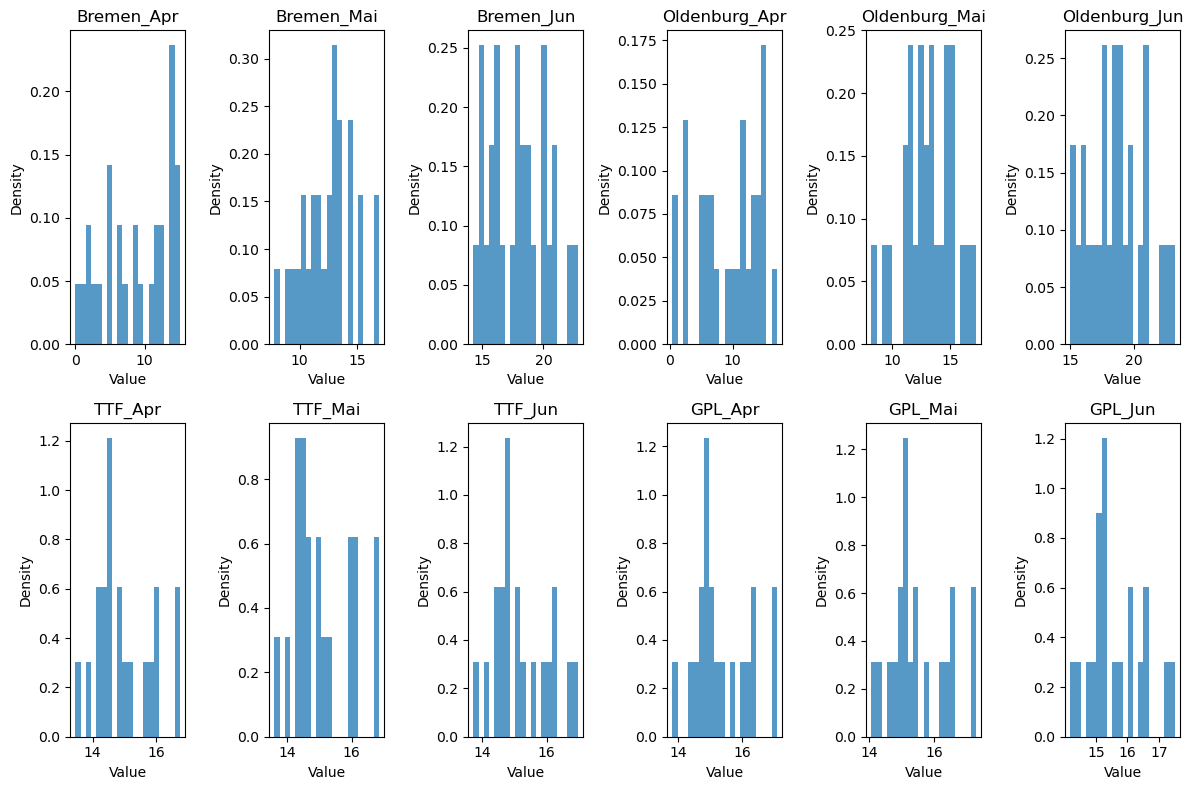

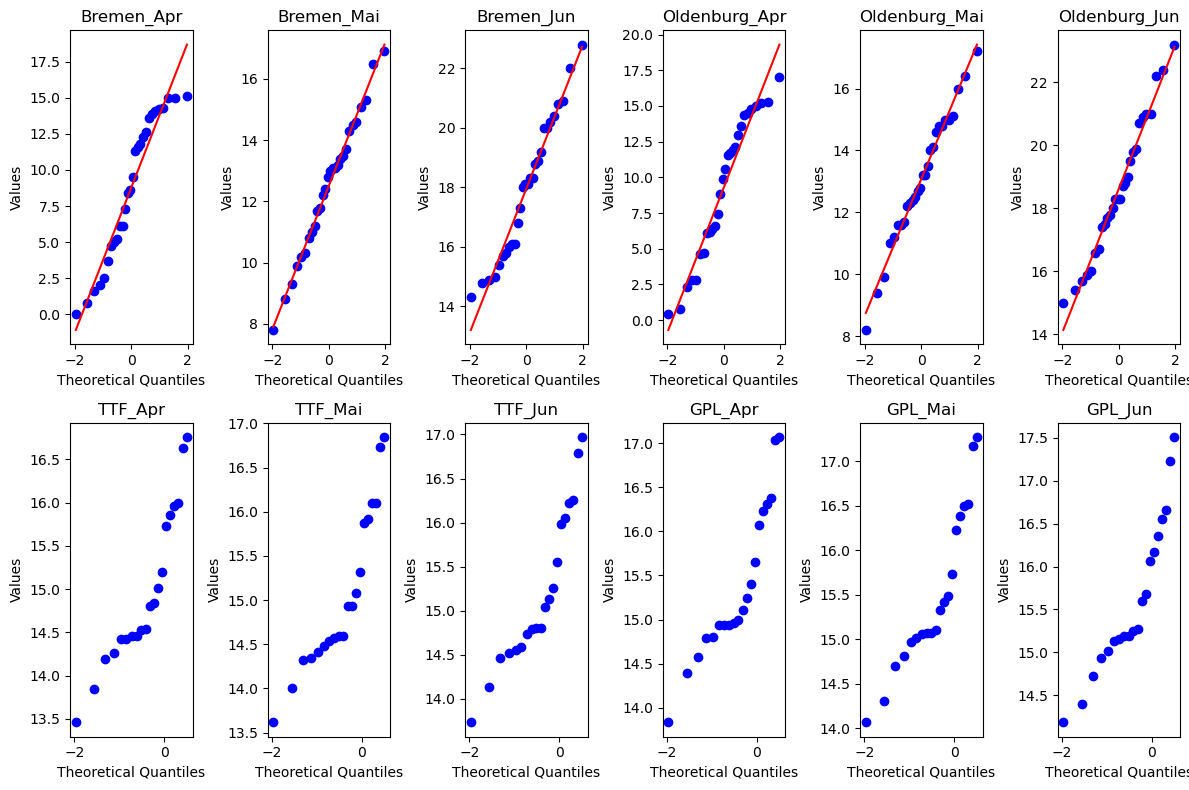

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Load data from CSV
file_path = 'challenge_data.csv'  # Replace with your file path
df = pd.read_csv(file_path, sep=';', decimal=',')

# Extract relevant columns for temperatures and prices
temp_columns = ['Bremen_Apr', 'Bremen_Mai', 'Bremen_Jun',
                'Oldenburg_Apr', 'Oldenburg_Mai', 'Oldenburg_Jun']
price_columns = ['TTF_Apr', 'TTF_Mai', 'TTF_Jun', 'GPL_Apr', 'GPL_Mai', 'GPL_Jun']

# Convert data from string format to float (assuming comma-separated decimals)
# for col in temp_columns + price_columns:
#     df[col] = df[col].str.replace(',', '.').astype(float)

# Plot histograms for each column (temperature and price)
plt.figure(figsize=(12, 8))
for i, col in enumerate(temp_columns + price_columns):
    plt.subplot(2, 6, i+1)
    plt.hist(df[col], bins=20, density=True, alpha=0.75)
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

# Q-Q plots for normality assessment
plt.figure(figsize=(12, 8))
for i, col in enumerate(temp_columns + price_columns):
    plt.subplot(2, 6, i+1)
    stats.probplot(df[col], dist="norm", plot=plt)
    plt.title(col)
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Values')

plt.tight_layout()
plt.show()
